Text(0, 0.5, 'Log(L/L$_\\odot$)')

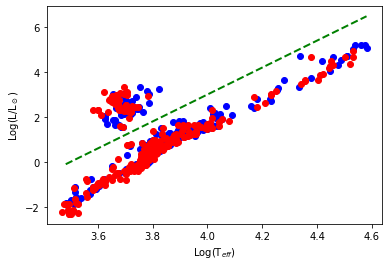

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import scipy
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import arviz as az
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
from scipy import stats

df = Table.read('https://www.astro.keele.ac.uk/jkt/debcat/debs.dat', format='ascii').to_pandas()

#filter out erroneous values
df = df[df['logL1'] > -3]

logT1 = df["logT1"]
logT1 = np.array(logT1)
logL1 = df["logL1"]
logL1 = np.array(logL1)

logT2 = df["logT2"]
logT2 = np.array(logT2)
logL2 = df["logL2"]
logL2 = np.array(logL2)

plt.scatter(logT1, logL1, color='blue')
plt.scatter(logT2, logL2, color='red')
plt.plot(logT1, 6*logT1 -21, color='green', linestyle='--', linewidth=2)
plt.xlabel('Log(T$_{eff}$)')
plt.ylabel('Log(L/L$_\odot$)')

In [3]:
#make the cut for red giant and main sequence for dataset 1
logR1_ms = df['logR1'][logL1 < (6*logT1-21)]
logR1_rg = df['logR1'][logL1 > (6*logT1-21)]

#make the cut for red giant and main sequence for dataset 2
logR2_ms = df['logR2'][logL1 < (6*logT1-21)]
logR2_rg = df['logR2'][logL1 > (6*logT1-21)]

#filter the errors for dataset 1
logR1_ms_err = df['logR1e'][logL1 < (6*logT1-21)]
logR1_rg_err = df['logR1e'][logL1 > (6*logT1-21)]

#filter the erros for dataset 2
logR2_ms_err = df['logR2e'][logL1 < (6*logT1-21)]
logR2_rg_err = df['logR2e'][logL1 > (6*logT1-21)]

#convert all data to numpy arrays
logR1_ms = np.array(logR1_ms)
logR1_rg = np.array(logR1_rg)
logR2_ms = np.array(logR2_ms)
logR2_rg = np.array(logR2_rg)

#convert all errors to numpy arrays
logR1_ms_err = np.array(logR1_ms_err)
logR1_rg_err = np.array(logR1_rg_err)
logR2_ms_err = np.array(logR2_ms_err)
logR2_rg_err = np.array(logR2_rg_err)

#concatenate all radii data into one array
radii_all = np.concatenate((logR1_ms, logR1_rg, logR2_ms, logR2_rg))

#concatenate all radius error data into one array
radii_all_err = np.concatenate((logR1_ms_err, logR1_rg_err, logR2_ms_err, logR2_rg_err))

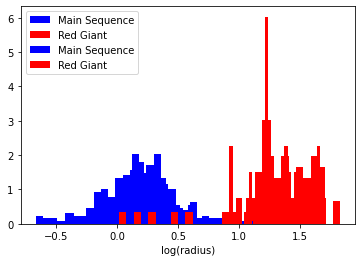

In [4]:
plt.hist(logR1_ms, color='blue', density=True, label='Main Sequence', bins=30)
plt.hist(logR1_rg, color='red', density=True, label='Red Giant', bins=30)
plt.hist(logR2_ms, color='blue', density=True, label='Main Sequence', bins=30)
plt.hist(logR2_rg, color='red', density=True, label='Red Giant', bins=30)
plt.xlabel('log(radius)')
plt.legend()

Text(0.5, 0, 'log(radius)')

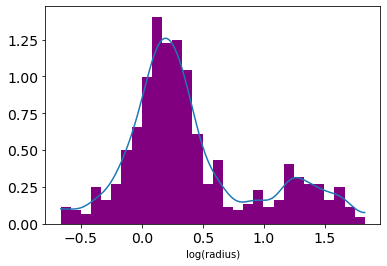

In [5]:
plt.hist(radii_all, color='purple', density=True, bins=30)
az.plot_kde(radii_all)
plt.xlabel('log(radius)')

### Model 1: Mixture with 2 normal distributions and a uniform distribution

In [17]:
#Include uniform distribution in the middle
k=3

with pm.Model() as mixture_3:
    w = pm.Dirichlet('w',a=np.ones(k))
    means = pm.Normal('means',mu=[0,1],tau=1e-3,shape=(2,))
    tau = pm.Gamma('tau',alpha=0.5, beta=0.5,shape=(2,))
    components = [
        pm.Normal.dist(mu=means[0],tau=tau[0], shape=(1,)),
        pm.Normal.dist(mu=means[1],tau=tau[1], shape=(1,)),
        pm.Uniform.dist(lower=-1,upper= 2),
    ]


    y = pm.Mixture('y', w=w, comp_dists=components, observed=radii_all)

    trace_3 = pm.sample(5000, chains=2, cores=4, init='jitter+adapt_diag',return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [w, means, tau]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 35 seconds.


array([[<AxesSubplot:title={'center':'means'}>,
        <AxesSubplot:title={'center':'means'}>],
       [<AxesSubplot:title={'center':'w'}>,
        <AxesSubplot:title={'center':'w'}>],
       [<AxesSubplot:title={'center':'tau'}>,
        <AxesSubplot:title={'center':'tau'}>]], dtype=object)

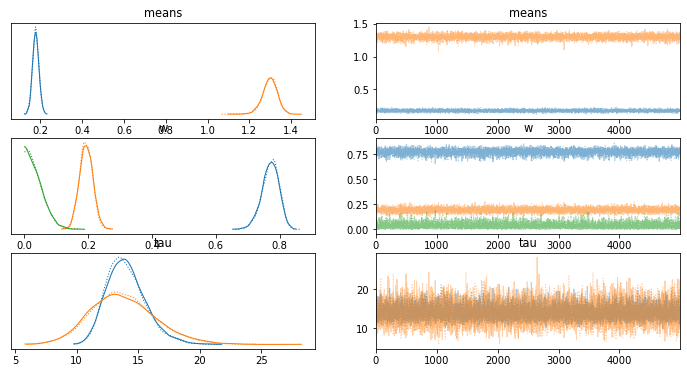

In [18]:
az.plot_trace(trace_3)

In [19]:
az.summary(trace_3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
means[0],0.178,0.015,0.149,0.207,0.000,0.000,7245.0,6462.0,1.0
means[1],1.298,0.035,1.231,1.364,0.000,0.000,6210.0,5492.0,1.0
w[0],0.771,0.027,0.719,0.818,0.000,0.000,5740.0,7928.0,1.0
w[1],0.193,0.021,0.154,0.232,0.000,0.000,9420.0,8785.0,1.0
w[2],0.036,0.027,0.000,0.085,0.000,0.000,4063.0,3139.0,1.0
tau[0],14.025,1.591,11.218,17.074,0.022,0.015,5434.0,6623.0,1.0
tau[1],13.770,2.628,9.114,18.978,0.030,0.022,7269.0,5785.0,1.0


array([[<AxesSubplot:title={'center':'w\n0'}>,
        <AxesSubplot:title={'center':'w\n0'}>],
       [<AxesSubplot:title={'center':'w\n1'}>,
        <AxesSubplot:title={'center':'w\n1'}>],
       [<AxesSubplot:title={'center':'w\n2'}>,
        <AxesSubplot:title={'center':'w\n2'}>]], dtype=object)

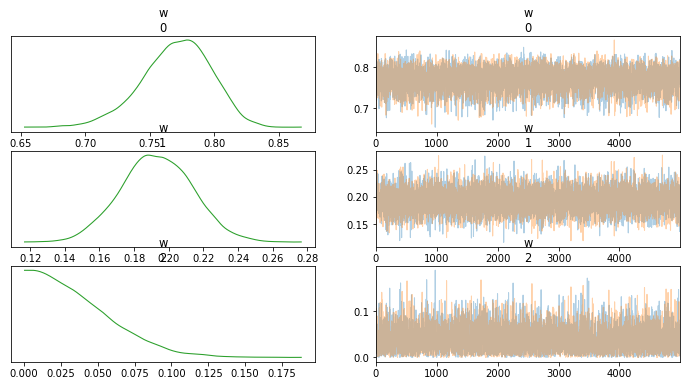

In [20]:
az.plot_trace(trace_3,['w'],combined=True,compact=False)

Sampling: [y]


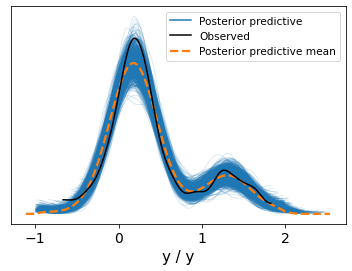

In [21]:
with mixture_3:
    pm.sample_posterior_predictive(trace_3, extend_inferencedata=True)

az.plot_ppc(trace_3, num_pp_samples=1000);